In [2]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib.axes as axe
import pandas as pd
import datetime as dt
import gurobipy as gp
from gurobipy import GRB
import cvxpy as cp

import random
from itertools import chain, combinations, tee
import time


# General CBCP Equilibrium Solver

## (Special Case) Quartic Polynomial Latency Functions

In [3]:
x_temp = np.array([0, 1, 2, 3, 4])
x_temp[-2:]

array([3, 4])

In [4]:
arr = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10], [11, 12, 13, 14, 15]])
# num_cols = arr.shape[1]
num_cols = 3
# arr[:, -num_cols:] - arr[:, -num_cols-1:-1]

np.linalg.norm(arr, axis=0)


array([12.56980509, 14.03566885, 15.55634919, 17.11724277, 18.70828693])

In [5]:
grad = np.array([0, 1, 2, 3, 4])

grad[2:]

array([2, 3, 4])

In [6]:
# Latency Function: a_4 x^4 + a_3 x^3 + a_2 x^2 + a_1 x + a_0

# def solve_CBCP_iter(v_ineligible_list, v_eligible_list, a = , num_iters = 1000, alpha_0 = ):
    
#     # TODO
    
#     return y_opt


def diff_vecs(arr):
    num_cols = arr.shape[1]
    diff_arr = arr[:, :num_cols - 1] - arr[:, 1:num_cols]
    
    return 

def solve_CBCP_iter_11(tau, B, v_I, v_E, a = np.array([0.5, 1.0]), input_flow = 1, \
                       num_iters_max = 5000, error_bound = 1E-3, diffs_num_cols = 10, \
                       y_init = np.array([0.0, 0.0, 1.0, 1.0, 0.0]) ):
    
    # y = (\hat y_1 E, \tilde y_1 E, y_2 E, y_1 I, y_2 I)
    # a = (a_0, a_1)
    
    # Initialize y_iters:
    y_iters = np.zeros((5, num_iters_max))
    
    y_el_var_current = y_init[0:3]
    y_in_var_current = y_init[3:]
    
    for k in range(num_iters_max):
        
        # y_el: \hat y_1 E, \tilde y_1 E, y_2 E
        y_el_var = cp.Variable(3)
        # y_in: y_1 I, y_2 I
        y_in_var = cp.Variable(2)
        
        # Compute gradient:
        
        grad = np.zeros(5)
        grad[0] = a[1] * (y_el_var_current[0] + y_el_var_current[1] + y_in_var_current[0]) + a[0] + tau / v_E
        grad[1] = a[1] * (y_el_var_current[0] + y_el_var_current[1] + y_in_var_current[0]) + a[0]
        grad[2] = a[1] * (y_el_var_current[2] + y_in_var_current[1]) + a[0]
        grad[3] = a[1] * (y_el_var_current[0] + y_el_var_current[1] + y_in_var_current[0]) + a[0] + tau / v_I
        grad[4] = a[1] * (y_el_var_current[2] + y_in_var_current[1]) + a[0]
        
        ## Apply Frank-Wolfe:
        # Compute next iterate:
        
#         objective = cp.Minimize(0.5 * a[1] * (y_el_var[0] + y_el_var[1] + y_in_var[0])**2 \
#                                 + a[0] * (y_el_var[0] + y_el_var[1] + y_in_var[0]) \
#                                 + y_in_var[0] * tau / v_I + y_el_var[0] * tau / v_E \
#                                 + 0.5 * a[1] * (y_el_var[2] + y_in_var[1])**2 \
#                                 + a[0] * (y_el_var[2] + y_in_var[1]) )
        
        objective = cp.Minimize(grad[0:3] @ y_el_var + grad[3:] @ y_in_var)

        constraints = []
        constraints += [y_el_var >= 0, y_in_var >= 0]
        constraints += [cp.sum(y_el_var) == 1, cp.sum(y_in_var) == 1]
        constraints += [y_el_var[1] * tau <= B]
    
        prob = cp.Problem(objective, constraints)
        result = prob.solve()
        
        y_el_var_current = y_el_var_current + 2/(k+2) * (y_el_var.value - y_el_var_current)
        y_in_var_current = y_in_var_current + 2/(k+2) * (y_in_var.value - y_in_var_current)
        
        y_iters[0:3, k] = y_el_var_current
        y_iters[3:, k] = y_in_var_current
        
        # TODO:        
        constraints = []
        constraints += [y_el_var >= 0, y_in_var >= 0]
        constraints += [cp.sum(y_el_var) == 1, cp.sum(y_in_var) == 1]
        constraints += [y_el_var[1] * tau <= B]

        prob = cp.Problem(objective, constraints)

        # The optimal objective value is returned by `prob.solve()`.
        result = prob.solve()
        # The optimal value for x is stored in `x.value`.
#         print("y_el.value:", y_el_var.value)
#         print("y_in.value:", y_in_var.value)
        
        if k >= diffs_num_cols + 1:
            diffs = np.linalg.norm(y_iters[:, -diffs_num_cols:] - y_iters[:, - diffs_num_cols - 1: -1], axis = 0)

            if np.max(diffs) < error_bound:
                break
    
    return y_el_var_current, y_in_var_current

def solve_CBCP_direct_11(tau, B, v_I, v_E, a = np.array([1, 0]), input_flow = 1):

    # y_el: \hat y_1, \tilde y_1, y_2
    y_el = cp.Variable(3)
    # y_in: y_1, y_2
    y_in = cp.Variable(2)
    
    objective = cp.Minimize(0.5 * a[1] * (y_el[0] + y_el[1] + y_in[0])**2 \
                            + a[0] * (y_el[0] + y_el[1] + y_in[0]) \
                            + y_in[0] * tau / v_I + y_el[0] * tau / v_E \
                            + 0.5 * a[1] * (y_el[2] + y_in[1])**2 \
                            + a[0] * (y_el[2] + y_in[1]) )
    
    constraints = []
    constraints += [y_el >= 0, y_in >= 0]
    constraints += [cp.sum(y_el) == 1, cp.sum(y_in) == 1]
    constraints += [y_el[1] * tau <= B]
    
    prob = cp.Problem(objective, constraints)
    
    # The optimal objective value is returned by `prob.solve()`.
    result = prob.solve()
    # The optimal value for x is stored in `x.value`.
    print("y_el.value:", y_el.value)
    print("y_in.value:", y_in.value)

    return y_el.value, y_in.value


In [83]:
def welfare_obj(lambda_E, lambda_R, lambda_I, tau, v_I, v_E, y_el, y_in, a):
    
    # y = (\hat y_1 E, \tilde y_1 E, y_2 E, y_1 I, y_2 I)
    # y_el = (\hat y_1 E, \tilde y_1 E, y_2 E)
    # y_in = (y_1 I, y_2 I)
    
    ell_1 = a[1] * (y_el[0] + y_el[1] + y_in[0]) + a[0]
    ell_2 = a[1] * (y_el[2] + y_in[1]) + a[0]
    
    obj_E = tau * y_el[0] + v_E * (ell_1 * (y_el[0] + y_el[1]) + ell_2 * y_el[2])
    
    # TODO

    obj_R = tau * (y_el[0] + y_in[0])

    obj_I = tau * y_in[0] + v_I * (ell_1 * (y_el[0] + y_el[1] + y_el[2]) + ell_2 * (y_in[0] + y_in[1]) )
    
    print("obj_E.shape:", obj_E.shape)
    print("obj_R:", obj_R)
    print("obj_I:", obj_I)

    return lambda_E * obj_E - lambda_R * obj_R + lambda_I * obj_I

    

In [8]:
# arr_temp = np.zeros(5)
# arr_temp[0] = 1

## Grid Search:

In [53]:
time_1 = time.time()

tau = 0.4
B = 0.3
v_I = 1.0
v_E = 0.6
a = np.array([0.5, 1.0])
input_flow = 1
num_iters_max = 5000
error_bound = 1E-3
diffs_num_cols = 5
y_init = np.array([0.0, 0.0, 1.0, 1.0, 0.0])
lambda_E, lambda_R, lambda_I = 1.0, 1.0, 1.0
# lambda_E, lambda_R, lambda_I = 1.0, 0.2, 1.0


grid_size = 0.05
tau_arr = (np.arange(int(1/grid_size)) + 1) * grid_size
B_arr = (np.arange(int(1/grid_size)) + 1) * grid_size

welfare_obj_arr = np.zeros((tau_arr.shape[0], B_arr.shape[0]))
y_el_arr = np.zeros((tau_arr.shape[0], B_arr.shape[0], 3))
y_in_arr = np.zeros((tau_arr.shape[0], B_arr.shape[0], 2))
welfare_obj_list = []

for tau_index, tau in enumerate(tau_arr):
    for B_index, B in enumerate(B_arr):
        if B < tau:
            print("tau:", tau)
            print("B:", B)
            y_el_arr[tau_index, B_index, :], y_in_arr[tau_index, B_index, :] \
                = solve_CBCP_iter_11(tau = tau, B = B, v_I = v_I, v_E = v_E, a = a, input_flow = input_flow, \
                                     num_iters_max = num_iters_max, error_bound = error_bound, diffs_num_cols = diffs_num_cols, \
                                     y_init = y_init)
            
            welfare_obj_arr[tau_index][B_index] = welfare_obj(lambda_E, lambda_R, lambda_I, tau, v_I, v_E, \
                                                              y_el = y_el_arr[tau_index, B_index, :], y_in = y_in_arr[tau_index, B_index, :], \
                                                              a = a)
            welfare_obj_list.append(welfare_obj_arr[tau_index][B_index])
            
            print()

time_2 = time.time()

print("Time:", time_2 - time_1)



tau: 0.1
B: 0.05

tau: 0.15000000000000002
B: 0.05

tau: 0.15000000000000002
B: 0.1

tau: 0.2
B: 0.05

tau: 0.2
B: 0.1

tau: 0.2
B: 0.15000000000000002

tau: 0.25
B: 0.05

tau: 0.25
B: 0.1

tau: 0.25
B: 0.15000000000000002

tau: 0.25
B: 0.2

tau: 0.30000000000000004
B: 0.05

tau: 0.30000000000000004
B: 0.1

tau: 0.30000000000000004
B: 0.15000000000000002

tau: 0.30000000000000004
B: 0.2

tau: 0.30000000000000004
B: 0.25

tau: 0.35000000000000003
B: 0.05

tau: 0.35000000000000003
B: 0.1

tau: 0.35000000000000003
B: 0.15000000000000002

tau: 0.35000000000000003
B: 0.2

tau: 0.35000000000000003
B: 0.25

tau: 0.35000000000000003
B: 0.30000000000000004

tau: 0.4
B: 0.05

tau: 0.4
B: 0.1

tau: 0.4
B: 0.15000000000000002

tau: 0.4
B: 0.2

tau: 0.4
B: 0.25

tau: 0.4
B: 0.30000000000000004

tau: 0.4
B: 0.35000000000000003

tau: 0.45
B: 0.05

tau: 0.45
B: 0.1

tau: 0.45
B: 0.15000000000000002

tau: 0.45
B: 0.2

tau: 0.45
B: 0.25

tau: 0.45
B: 0.30000000000000004

tau: 0.45
B: 0.35000000000000003

In [62]:
# welfare_obj_arr

argmin_indices_wrapped = np.where(welfare_obj_arr == min(welfare_obj_list))
argmin_indices = [argmin_indices_wrapped[0][0], argmin_indices_wrapped[1][0]]
# argmin_indices
argmin_tau = tau_arr[argmin_indices[0]]
argmin_B = B_arr[argmin_indices[1]]
argmin_tau, argmin_B


(0.8500000000000001, 0.7000000000000001)

In [79]:
welfare_obj_list

[3.9122448979591833,
 3.9122448979591837,
 3.9122448979591837,
 3.9122448979591837,
 3.9122448979591837,
 3.9122448979591837,
 3.9611632653061224,
 3.920571428571429,
 3.9431020408163264,
 3.925469387755102,
 3.9699404761904757,
 3.9318027210884354,
 3.9535714285714287,
 3.9367346938775514,
 3.9229591836734694,
 3.976561849229488,
 3.9412328196584756,
 3.9164618908788005,
 3.945980841316118,
 3.932486463973344,
 3.9212411495210326,
 3.900478316326531,
 3.8996173469387756,
 3.919730548469388,
 3.9057397959183677,
 3.8998325892857144,
 3.902008928571429,
 3.8761080994897963,
 3.9535714285714287,
 3.9991685563114134,
 3.947619047619048,
 3.910959939531368,
 3.9178193499622074,
 3.9027210884353742,
 3.9402116402116407,
 3.924338624338623,
 3.972,
 4.011673469387755,
 3.9611632653061224,
 3.920571428571429,
 3.929464285714286,
 3.910469387755102,
 3.9535714285714287,
 3.9367346938775514,
 3.8762602040816327,
 4.083673469387755,
 4.022448979591837,
 3.973469387755102,
 3.9306122448979592,
 3

In [55]:
# # lambda_E, lambda_R, lambda_I = 1.0, 0.2, 1.0

# plt.imshow(welfare_obj_arr.T, vmin = min(welfare_obj_list), vmax = max(welfare_obj_list), origin='lower' ) 
# plt.colorbar() 
# plt.xlabel("Toll") 
# plt.ylabel("Budget")

Text(0, 0.5, 'Budget')

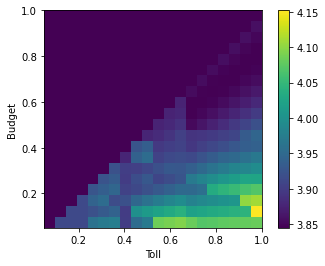

In [69]:
# lambda_E, lambda_R, lambda_I = 1.0, 1.0, 1.0

# plt.imshow(welfare_obj_arr.T, vmin = min(welfare_obj_list), vmax = max(welfare_obj_list), origin='lower') 
plt.imshow(welfare_obj_arr.T, extent=[np.min(tau_arr), np.max(tau_arr), np.min(B_arr), np.max(B_arr)], \
           vmin = min(welfare_obj_list), vmax = max(welfare_obj_list), origin='lower') 

plt.colorbar() 
plt.xlabel("Toll")
plt.ylabel("Budget")
# plt.xticks(x_positions, x_labels)

## Chinmay's Algorithm:

## (To edit, below)

In [87]:
time_1 = time.time()

tau = 0.4
B = 0.3
v_I = 1.0
v_E = 0.6
a = np.array([0.5, 1.0])
input_flow = 1
num_iters_max = 5000
error_bound = 1E-3
diffs_num_cols = 5
y_init = np.array([0.0, 0.05, 0.95, 0.95, 0.05])
lambda_E, lambda_R, lambda_I = 1.0, 1.0, 1.0
# lambda_E, lambda_R, lambda_I = 1.0, 0.2, 1.0

tau_max, B_max = 1.0, 1.0
d = 2
num_iters = 1000
tau = np.zeros(num_iters)
tau_perturbed = np.zeros(num_iters)
B = np.zeros(num_iters)
B_perturbed = np.zeros(num_iters)
delta = np.zeros(num_iters)
eta = np.zeros(num_iters)
eta_bar = 1.0
delta_bar = 1.0

B[0] = 0.4
tau[0] = 0.5

for i in range(num_iters):
    eta[i] = eta_bar * (i+1)**(-1/2) * d**(-1)
    delta[i] = delta_bar * (i+1)**(-1/4) * d**(-1/2)
    w_i_unnormalized = np.random.randn(2)
    w_i = w_i_unnormalized / np.linalg.norm(w_i_unnormalized)
    print("w_i:", w_i)
    tau_perturbed[i] = tau[i] + delta[i] * w_i[0]
    B_perturbed[i] = B[i] + delta[i] * w_i[1]
    y_el, y_in = solve_CBCP_iter_11(tau = tau[i], B = B[i], v_I = v_I, v_E = v_E, a = a, input_flow = input_flow, \
                                     num_iters_max = num_iters_max, error_bound = error_bound, diffs_num_cols = diffs_num_cols, \
                                     y_init = y_init)
    y_el_perturbed, y_in_perturbed = solve_CBCP_iter_11(tau = tau_perturbed[i], B = B_perturbed[i], v_I = v_I, v_E = v_E, a = a, input_flow = input_flow, \
                                                        num_iters_max = num_iters_max, error_bound = error_bound, diffs_num_cols = diffs_num_cols, \
                                                        y_init = y_init)
    
    print("y_el:", y_el)
    print("y_in:", y_in)
    print("y_el_perturbed:", y_el_perturbed)
    print("y_in_perturbed:", y_in_perturbed)
    
    welfare = welfare_obj(lambda_E, lambda_R, lambda_I, tau, v_I, v_E, y_el = y_el, y_in = y_in, a = a)
    welfare_perturbed = welfare_obj(lambda_E, lambda_R, lambda_I, tau, v_I, v_E, \
                                    y_el = y_el_perturbed, y_in = y_in_perturbed, a = a)
    
    print("welfare:", welfare)
    print("welfare_perturbed:", welfare_perturbed)
    print("tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):\n", tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare))
    
    tau[i+1] = tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare)
    B[i+1] = B[i] - eta[i] * (d/delta[i]) * w_i[1] * (welfare_perturbed - welfare)



time_2 = time.time()

print("Time:", time_2 - time_1)



w_i: [-0.958464    0.28521355]
y_el: [0.01428571 0.34285714 0.64285714]
y_in: [0.42857143 0.57142857]
y_el_perturbed: [0.57142857 0.         0.42857143]
y_in_perturbed: [0.57142857 0.42857143]
obj_E.shape: (1000,)
obj_R: [0.22142857 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         

ValueError: setting an array element with a sequence.

In [29]:
# y_el_var
# y_in_var
# np.hstack((y_el_var, y_in_var))

# Scratch Work:

In [4]:
x = cp.Variable(2)
y = cp.Variable(2)
v_fixed = np.array([0, 1])
objective = cp.Minimize(cp.sum_squares(x - y) + cp.sum_squares(x - v_fixed))
constraints = []
# for i in range(2):
#     constraints += [x[i] >= 2]
# constraints += [x[i] >=2 for i in range(2)]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
print("x.value:", x.value)
print("y.value:", y.value)
print()


x.value: [-0.  1.]
y.value: [-0.  1.]



# Old Code Below:

# Budget vs Discount - Theory

## 1 Eligible group, 1 Ineligible group (Theory)

In [2]:
def F_11(val, ell, tau, alpha):
    return ell(val) + (1 - alpha) * tau - ell(2 - val)

def y_star_11(ell, tau, alpha, lb_init = 0.0, ub_init = 2.0, num_iters = 20):
    # Searches for y^\star satisfying ell(y^\star) + (1 - \alpha) \tau = ell(2 - y^\star)
    
    assert tau < ell(ub_init) - ell(lb_init), "We must have tau < ell(2.0) - ell(0.0), else is trivial."
    assert 0.0 <= alpha <= 1.0, "We must have 0.0 <= alpha <= 1.0"
    assert ell(lb_init) + (1.0 - alpha) * tau < ell(ub_init)
    
    lb = lb_init
    ub = ub_init
    mid_val = (lb + ub)/2
    
    for k in range(num_iters):
#         print("F:", F_11(mid_val, ell, tau, alpha))
#         print("lb:", lb)
#         print("ub:", ub)
#         print("mid_val:", mid_val)
#         print()
        
        if F_11(mid_val, ell, tau, alpha) < 0:
            lb = mid_val
        else:
            ub = mid_val
        mid_val = (lb + ub)/2
    
    return (lb + ub)/2

# def fixed_point_eqn():
    


In [3]:
t_1 = time.time()

ell = lambda x: x**4 / 16
# ell = lambda x: np.log(1 + np.exp(x))
# alpha = 0.0

# # Case 1: 
# tau = 0.4
# v_E = 1
# v_I = 1.25

# # Case 2: 
# tau = 0.7
# v_E = 1
# v_I = 1.25

# Case 3: 
tau = 0.7
v_E = 1
v_I = 2.5

num_alpha_grid_points = 100 # Should be even
alpha_vals = np.linspace(0, 1.0, num = num_alpha_grid_points + 1)

y_star_zero = y_star_11(ell, tau, alpha = 0.0, lb_init = 0.0, ub_init = 2.0)
# print("y_star_zero:", y_star_zero)

y_star_vals = np.array([y_star_11(ell, tau, alpha, lb_init = 0.0, ub_init = 2.0) for alpha in alpha_vals])
y_star_vals_budget = alpha_vals
index_max = max([k for k in list(range(num_alpha_grid_points)) if alpha_vals[k] <= 1 - v_E/v_I])
# print("index_min:", index_min)
# print("alpha_vals[index_min]:", alpha_vals[index_min])
# print("y_star_vals_budget:", y_star_vals_budget)
# print()

# print("y_star_vals:", y_star_vals)
# print()

y_star_vals_discount = np.copy(y_star_vals)
for k in range(y_star_vals_discount.shape[0]):
    if k <= index_max:
        y_star_vals_discount[k] = 0.0

tau_thresh_for_alpha_3 = 2 * v_E * (ell(1) - ell(1 - 1E-6)) / 1E-6
index_for_alpha_3 = max([k for k in list(range(num_alpha_grid_points)) if y_star_vals[k] >= alpha_vals[k] ])
alpha_3 = (y_star_vals[index_for_alpha_3] + y_star_vals[index_for_alpha_3 + 1])/2

# print("y_star_vals_budget:", y_star_vals_budget)

# print("y_star_vals_budget:", y_star_vals_budget)


t_2 = time.time()
print("Time:", t_2 - t_1)

Time: 0.005392313003540039


In [4]:
print("1 - v^E / v^I:", 1 - v_E/v_I)
print("alpha_3:", alpha_3)

1 - v^E / v^I: 0.6
alpha_3: 0.365936279296875


Text(0, 0.5, '$\\displaystyle y^C, y^D$')

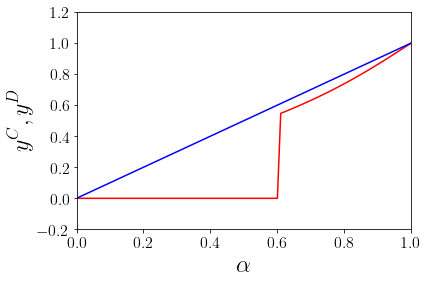

In [6]:
plt.rcParams['text.usetex'] = True
# plt.rcParams['text.usetex'] = False

plt.plot(alpha_vals, y_star_vals_discount, 'red')
plt.plot(alpha_vals, y_star_vals_budget, 'blue')
# plt.scatter(alpha_vals, y_star_vals_discount, marker = 'o', s = 0.5, color = 'purple')
# plt.scatter(alpha_vals, y_star_vals_budget, marker = 'o', s = 0.5, color = 'black')
plt.xlim([0, 1.0])
plt.ylim([-0.2, 1.2])

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel(r'$\displaystyle \alpha$', fontsize=24)
plt.ylabel(r'$\displaystyle y^C, y^D$', fontsize=24)
# plt.ylabel(r'$\displaystyle \ln(L^t - L^\star)$', fontsize=16)

# Scratch Work:

In [ ]:
# m_sample = gp.Model()
